# Tarea 3
### Vicente Illanes Venegas

In [1]:
# para crear copias de los arboles
from copy import deepcopy
# random
import random
import operator, random, string
import matplotlib.pyplot as plt

In [2]:
# esta funcion dice si el argumento es una funcion o no
def is_function(f):
    return hasattr(f, "__call__")

# esto nos permite recorrer una lista de a pedazos
# ejemplo el input es [1,2,3,4,5,6,7,8]
# con n=2 esta funcion nos hara tener
# [(1,2), (3,4), (5,6), (7,8)]
def chunks(iterable, n):
    for i in range(0, len(iterable), n):
        yield iterable[i:i + n]

# Clase Nodo


In [3]:
class Node:
    def __init__(self, function):
        # nos aseguramos que el nodo recibe una funcion
        assert is_function(function)
        self.operation = function
        # esto nos permite contar cuantos argumentos recibe la funcion
        self.num_arguments = function.__code__.co_argcount
        self.arguments = []
        
    # funcion para evaluar un nodo (calcular el resultado)
    def eval(self, dicc):
        # es importante chequear que los argumentos que nos dieron
        # coincidan con los argumentos que necesitamos
        assert len(self.arguments) == self.num_arguments
        # evaluamos los argumentos, y luego los pasamos como argumentos a
        # la operacion
        # NOTA: esto -> *[...] significa que separa los elementos de la lista
        # ejemplo si tenemos `lista = [1,2,3]`
        # print(lista) -> [1,2,3]
        # print(*lista) -> 1 2 3
        # esto se llama `unpacking`.
        # lo necesitamos porque nuestra funcion recibe N argumentos
        # no una lista de tamaño N.
        return self.operation(*[node.eval(dicc) for node in self.arguments])
    
    # hace una lista con todos los hijos
    def serialize(self):
        l = [self]
        for node in self.arguments:
            l.extend(node.serialize())
        return l
    
    # copia al nodo
    def copy(self):
        return deepcopy(self)
    
    # reemplaza el nodo por otro
    def replace(self, otherNode):
        # aqui estamos haciendo algo medio hacky.
        # la forma correcta seria tener una referencia al nodo padre y
        # reemplazarse a si mismo por otro.
        # por temas de mantener el codigo corto lo hacemos asi
        # pero no lo hagan en casa!
        assert isinstance(otherNode, Node)
        self.__class__ = otherNode.__class__
        self.__dict__ = otherNode.__dict__
        
    


In [4]:
# esta clase representa todos los nodos que tienen 2 argumentos
class BinaryNode(Node):
    num_args = 2
    def __init__(self, function, left, right):
        # revisamos que todo sea un nodo y agregamos a las lista de
        # argumentos
        assert isinstance(left, Node)
        assert isinstance(right, Node)
        super(BinaryNode, self).__init__(function)
        self.arguments.append(left)
        self.arguments.append(right)
        
    def terminals(self):
        return self.arguments[0].terminals() + self.arguments[1].terminals()




In [5]:
class AddNode(BinaryNode):
    def __init__(self, left, right):
        def _add(x,y):
            return x + y
        super(AddNode, self).__init__(_add, left, right)
        
    # esta es la funcion que define como se mostrara el nodo
    # como es un nodo que REPResenta la suma, lo mostramos como suma
    def __repr__(self):
        return "({} + {})".format(*self.arguments)
        
    
class SubNode(BinaryNode):
    def __init__(self, left, right):
        def _sub(x,y):
            return x - y
        super(SubNode, self).__init__(_sub, left, right)
        
    def __repr__(self):
        return "({} - {})".format(*self.arguments)
    
    
class MaxNode(BinaryNode):
    def __init__(self, left, right):
        def _max(x,y):
            return max(x,y)
        super(MaxNode, self).__init__(_max, left, right)
        
    def __repr__(self):
        return "max({{{}, {}}})".format(*self.arguments)


class MultNode(BinaryNode):
    def __init__(self, left, right):
        def _mult(x,y):
            return x * y
        super(MultNode, self).__init__(_mult, left, right)
        
    def __repr__(self):
        return "({} * {})".format(*self.arguments)
    
    
class TerminalNode(Node):
    # Este nodo representa una hoja de arbol. Es el nodo terminal
    # por lo que no tiene argumentos
    num_args = 0
    def __init__(self, value):
        # igual tenemos que representarlo como una funcion, por como
        # diseñamos el programa. Pero aqui va a ser una funcion vacia
        def _nothind(): pass
        super(TerminalNode, self).__init__(_nothind)
        self.value = value
        
    def __repr__(self):  
        return str(self.value)
    
    def eval(self, dicc):
        #SOPORTAR VARIABLES
        if isinstance(self.value, str):
            return dicc[self.value]
        # la evaluacion de un nodo terminal es el valor que contiene
        return self.value
    
    def terminals(self):
        return [self.value]

## Generador de árboles aleatorio

# AST

In [6]:
# un AST es un arbol que representa un programa, la idea aqui es tener 
# un generador, que pueda generar ASTs aleatorios
class AST:
    def __init__(self, allowed_functions, allowed_terminals, prob_terminal=0.3):
        # las funciones (nodos en nuestro caso) que nuestro programa puede tener
        self.functions = allowed_functions
        # los terminales admitidos en nuestro programa. Numeros por ejemplo
        self.terminals = allowed_terminals
        # para no tener un arbol infinitamente profundo, existe una posibilidad
        # de que, a pesar de que ahora toque hacer otro sub arbol, que se ignore
        # eso y se ponga un terminal en su lugar.
        self.prob = prob_terminal

    # esta funcion ya la hemos visto, nos permite llamar al AST como si fuera
    # una funcion. max_depth es la produndidad que queremos tenga el arbol
    def __call__(self, max_depth=10):
        # aqui tenemos una funcion auxiliar. Nos permitira hacer esto recursivo
        def create_rec_tree(depth):
            # si `depth` es mayor a 0, nos toca crear un sub-arbol
            if depth > 0:
                # elegimos una funcion aleatoriamente
                node_cls = random.choice(self.functions)
                # aqui iremos dejando los argumentos que necesita la funcion
                arguments = []
                # para cada argumento que la funcion necesite...
                for _ in range(node_cls.num_args):
                    # existe un `prob` probabilidad de que no sigamos creando
                    # sub-arboles y lleguemos y cortemos aqui para hacer
                    # un nodo terminal
                    if random.random() < self.prob:
                        arguments.append(create_rec_tree(0))
                    else:
                        # la otra es seguir creando sub-arboles recursivamente
                        arguments.append(create_rec_tree(depth - 1))
                
                # `arguments` es una lista y los nodos necesitan argumentos
                # asi que hacemos "unpacking" de la lista
                return node_cls(*arguments)
            else:
                # si `depth` es 0 entonces creamos un nodo terminal con
                # alguno de los terminales permitidos que definimos inicialmente
                return TerminalNode(random.choice(self.terminals))

        # llamamos a la funcion auxiliar para crear un arbol de profundidad `max_depth`
        return create_rec_tree(max_depth)

In [7]:
#funcion de fitness: puntaje máximo numero objetivo, puntaje mínimo: 0
#individual: representa un programa
#goal: objetivo 
def fitness(individual, goal):
    eval = individual.eval({})
    return max(-abs(eval - goal) + goal, 0)

#funcion de fitness que castiga repetición de terminales
def fitness_repetion(individual, goal, ast):
    for t in ast.terminals:
        if(individual.terminals().count(t) > 1):
            return 0
    
    eval = individual.eval({})
    return max(-abs(eval - goal) + goal, 0)

#funcion de fitness que castiga tamanio del programa
def fitness2(individual, goal):
    eval = individual.eval({})
    return max(-abs(eval - goal) + goal - len(individual.serialize())/2, 0)

def rank(population, fitness, goal):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = fitness(population[i], goal)
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse= True)

#Retorna una lista de los indices de los individuos seleccionados que dejaran herencia
#ranking: lista de los individuos rankeados (indice, fitness)
#elite: elitimismo
def selection(ranking, elite):
    selection = []
    for i in range(0, elite):
        selection.append(ranking[i][0])
    
    #Ruleta
    #suma = 0
    #for i in range(len(ranking)):
    #  suma += ranking[i][1]  
    #for i in range(0, len(ranking) - elite):
    #  current = 0
    #  p = random.uniform(0, suma)
    #  for i in range(0, len(ranking)):
    #    current += ranking[i][1]
    #    if current > p:
    #      selection.append(ranking[i][0])
    #      break
    
    #torneo. se seleccionan 5 al azar, se agrega al mejor
    for i in range(0, len(ranking) - elite):
        better = int(random.uniform(0, len(ranking)))
        for j in range(0, 4):
            p = int(random.uniform(0, len(ranking)))
            if ranking[better][1] > ranking[p][1]:
                better = p
        selection.append(ranking[better][0])
    
    return selection

#Retorna lista definitiva de los elementos seleccionados para dejar una nueva generacion
def selectionPopulation(population, selection):
    parents = []
     
    for i in range(len(selection)):
        index = selection[i]
        parents.append(population[index])
    
    return parents


In [8]:
#REPRODUCCION
def crossover(parent1, parent2):
    new_child = parent1.copy()
    #genes para particion
    genA = int(random.random() * len(parent1.serialize()))
    genB = int(random.random() * len(parent2.serialize()))
    
    cross = (parent2.serialize()[genB]).copy()
    
    new_child.serialize()[genA].replace(cross)
  
    return new_child

In [9]:
#retorna poblacion de descendientes  
def crossoverPopulation(parents, elite):
    children = []
    length = len(parents) - elite
    random_parents = random.sample(parents, len(parents))

    for i in range(0,elite):
        children.append(parents[i])
    
    for i in range(0, length):
        child = crossover(random_parents[i], random_parents[len(parents) -i -1])
        children.append(child)
    return children

In [10]:
#Muta un individuo
#mutatioRate = tasa de mutacion
#generate_gen = generador de genes

def mutate(individual, generate_gen, mutationRate):
    
    actual = individual.copy()
    if(random.random()<mutationRate):
        actual = crossover(actual, generate_gen()) 
    return actual

#Mutacion de una poblacion
def mutatePopulation(population, generate_gen, mutationRate):
  mutated = []
  
  for i in range(len(population)):
    mutated.append(mutate(population[i], generate_gen, mutationRate))
    
  return mutated

In [11]:
#Avanze de una generacion completo
def evolution(currentPopulation, generate_gen, fitness, elite, mutationRate, goal):
    ranking = rank(currentPopulation, fitness, goal)
    selected = selection(ranking, elite)
    parents = selectionPopulation(currentPopulation, selected)
    children = crossoverPopulation(parents, elite)
    nextPopulation = mutatePopulation(children, generate_gen, mutationRate)
    return nextPopulation

In [12]:
def average(ranking):
  suma = 0
  for i in range(len(ranking)):
    suma += ranking[i][1]
  return suma/ len(ranking)

def genetic_algorithm(pop_size, fitness, generate_gen, elite, mutationRate, generations,deep= 10, goal=None, heatmap=False):
    population = []
    progress = []
    worse = []
    avg = []
  
    N = deep
    
    for i in range(0,pop_size):
        population.append(generate_gen(N))
      
    initialRank = rank(population, fitness, goal)
    progress.append(initialRank[0][1])
    worse.append(initialRank[-1][1])
    avg.append(average(initialRank))
  
    generation = generations
    for i in range(0, generations):
        population = evolution(population, generate_gen, fitness, elite, mutationRate, goal)
        currentRank = rank(population, fitness, goal)
        progress.append(currentRank[0][1])
        worse.append(currentRank[-1][1])
        avg.append(average(currentRank))
        if(currentRank[0][1] == goal):
            generation = i
            break
    
    if(heatmap):
        return generation
    else:
        print(population[currentRank[0][0]])
        try: 
            print(population[currentRank[0][0]].eval({}))
        except: 
            print("ecuacion")
        plt.plot(progress, "b", label="Progress")
        plt.plot(avg, "g", label="Average")
        plt.plot(worse, "r", label="Worse")
        plt.ylabel('Value')
        plt.xlabel('Generation')
        plt.title("Máximo, Mínimo y Promedio en el tiempo")

        legend = plt.legend(loc='best', shadow=True)
        plt.show()
    

## Encontrar Numero
Para este problema se tuvo que crear un método para el ast uniqueTerminal, el cual permite crear programas pero con la limitante de incluir 0 o 1 vez cada valor

In [13]:
ast = AST([AddNode, SubNode, MultNode], [2,3, 5])

(5 * 2)
10


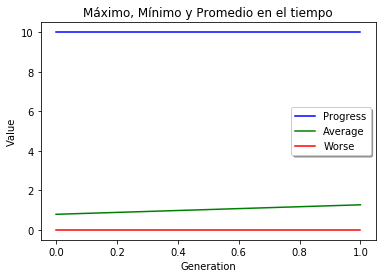

In [14]:
genetic_algorithm(100, lambda a, b: fitness_repetion(a,b,ast), ast, 5, mutationRate=0.3, generations=200, deep= 2, goal=10, heatmap=False)

## Encontrar número. Sin límite de repeticiones

In [15]:
ast = AST([AddNode, SubNode, MultNode, MaxNode], [25, 7, 8, 100, 4, 2])

((((7 * 7) * (8 * 25)) * 7) - ((8 * 7) + max({(25 * 7), 7})))
68369


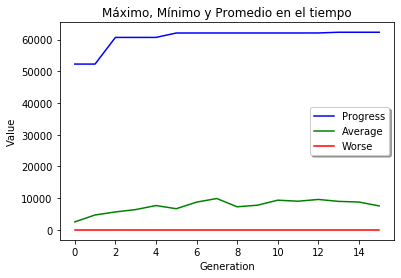

In [16]:
genetic_algorithm(100, fitness2, ast, 10, mutationRate=0.3, generations=15, deep= 4, goal=65346, heatmap=False)

## Sin Repeticiones

(2 * (max({4, (8 * 25)}) * 100))
40000


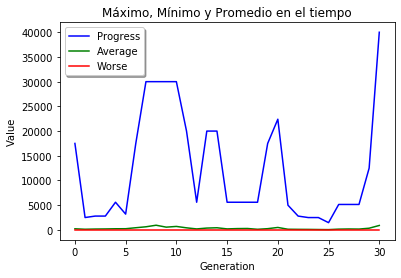

In [17]:
genetic_algorithm(100, lambda a, b: fitness_repetion(a,b,ast), ast, 10, mutationRate=0.3, generations=30, deep= 2, goal=65346, heatmap=False)

## Implementar variables

In [18]:
ast = AST([AddNode, SubNode, MultNode], [25, 7, 8, 100, 4, 2, 'x'])

In [19]:
r = ast(3)
r

(((2 * 2) * (4 - 4)) + ((8 + 4) - (4 * x)))

In [20]:
r.eval({'x' : 4, 'y': 0})

-4

## Symbolic Regression

In [21]:
def f(x):
    return x*x + x - 6

def fitness_func(individual, goal, func_goal):
    points= 0    
    for i in range(-100, 100):
        val = func_goal(i)
        try:
            aprox = individual.eval({'x': i})
        except:
            return 0
        if abs(val - aprox) < 1:
            points += 1
    return points
        

(((((x * ((x + x) + (4 - x))) + ((x + ((((((((8 * (8 * -5)) * 0) - (x * ((x - x) - (x + x)))) + ((((x + 7) - x) + ((x * x) - (-8 * x))) - (-10 * 2))) - 4) - 2) + ((-5 * -1) - -9)) - (((3 * ((x - -2) + (-6 + 2))) + (-9 + 6)) * x))) - ((x + (((-2 * 3) * x) * (x - (x - 7)))) - (x - -8)))) - ((((1 - (x + x)) * 4) * ((x * x) - x)) - (((-5 + x) * ((((-6 + x) * (x - (x * x))) - (2 + (10 - x))) + (8 + (-8 - (x * 9))))) + ((((x + (7 + 4)) * ((-7 * -4) - (x + x))) * (((x + x) + (8 - -1)) * (7 * (x * x)))) - 1)))) * (x + x)) * (x - x))
ecuacion


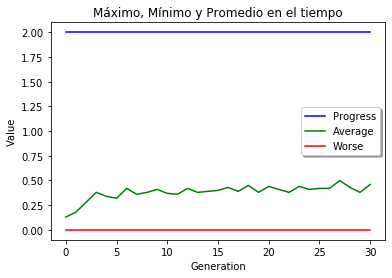

In [22]:
ast = AST([AddNode, SubNode, MultNode], [-10, -9, -8, -7, -6, -5, -4,-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7 , 8, 9, 10, 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'])
genetic_algorithm(100, lambda a,b: fitness_func(a,b,f), ast, 10, mutationRate=0.3, generations=30, deep= 10, goal=200, heatmap=False)

## Implementacion Division

In [23]:
import math
class DivNode(BinaryNode):
    def __init__(self, left, right):
        def _div(x,y):
                return x / y
        super(DivNode, self).__init__(_div, left, right)
        
    def __repr__(self):
        return "({} / {})".format(*self.arguments)

((((-4 + (-6 + -1)) / 1) - -5) - ((x - (x + x)) - (x * x)))
ecuacion


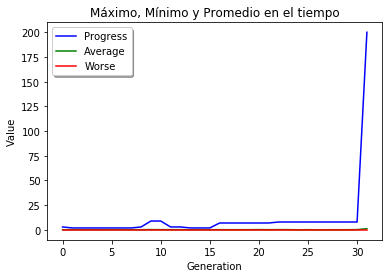

In [24]:
ast = AST([AddNode, SubNode, MultNode, DivNode], [-10, -9, -8, -7, -6, -5, -4,-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7 , 8, 9, 10, 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'])
genetic_algorithm(200, lambda a,b: fitness_func(a,b,f), ast, 10, mutationRate=0.3, generations=40, deep= 5, goal=200, heatmap=False)


In [25]:
def heatmap():
    i = 50
    size = []
    generations = []
    ast = AST([AddNode, SubNode, MultNode], [25, 7, 8, 100, 4, 2, 3])
    while(i <= 1000):
        size.append(i)        
        generations.append(genetic_algorithm(i, lambda a, b: fitness_repetion(a,b,ast), ast, 10, mutationRate=0.3, generations=100, deep= 2, goal=375, heatmap=True))
        i+=50
        print(i)
    
    plt.plot(size, generations,color='r', label='Tiempo')
    plt.ylabel('Generation')
    plt.xlabel('Population Size')
    plt.title("Generación de éxito v/s tamaño de la población")
  
    plt.show()

100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050


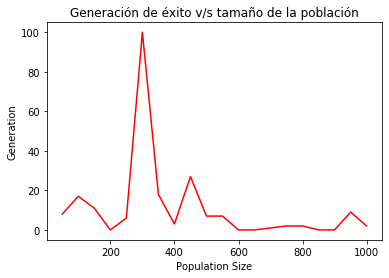

In [27]:
heatmap()

In [30]:
def heatmap2():
    i = 0.0
    size = []
    generations = []
    ast = AST([AddNode, SubNode, MultNode], [25, 7, 8, 100, 4, 2, 3])
    while(i <= 1):
        size.append(i)        
        generations.append(genetic_algorithm(250, lambda a, b: fitness_repetion(a,b,ast), ast, 10, mutationRate=i, generations=100, deep= 2, goal=375, heatmap=True))
        i+=0.1
        print(i)
    
    plt.plot(size, generations,color='r', label='Tiempo')
    plt.ylabel('Generation')
    plt.xlabel('Population Size')
    plt.title("Generación de éxito v/s tasa de mutación")
  
    plt.show()

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7
0.7999999999999999
0.8999999999999999
0.9999999999999999
1.0999999999999999


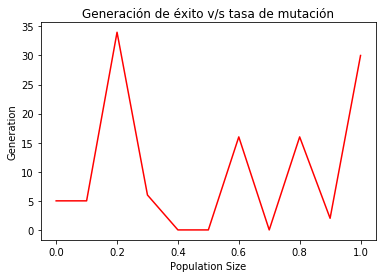

In [31]:
heatmap2()